<div class="alert alert-block alert-success">
    <b><center>Pytorch LIBRARY</center></b>
    <b><center>CIFAR 10</center></b>
</div>

# Configure Learning Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Prepare Data

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])
res_train = datasets.CIFAR10("./datas", train=True, transform=transform, download=True)
res_valid = datasets.CIFAR10("./datas", train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
load_train = torch.utils.data.DataLoader(res_train, batch_size=100, shuffle=True)
load_valid = torch.utils.data.DataLoader(res_valid, batch_size=100, shuffle=True)

In [6]:
iter_train = iter(load_train)
images, labels = iter_train.next()
images.shape, labels.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [7]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 255)
    return image

In [8]:
class_cifar = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

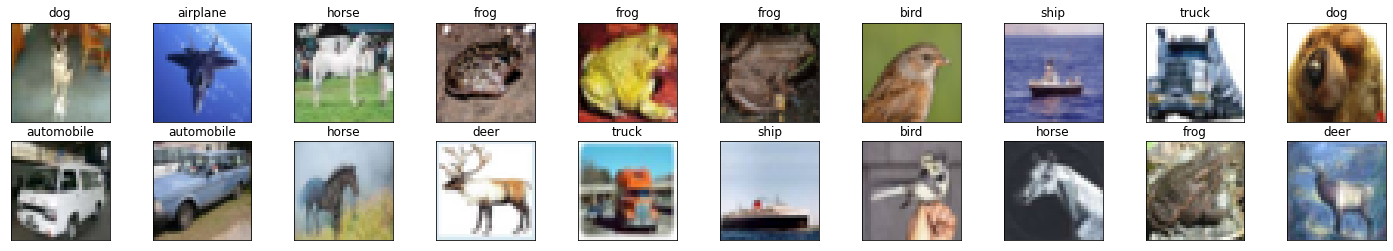

In [ ]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(class_cifar[labels[idx].item()])

# Generate Model

In [43]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*5*50, 500)
        self.act3 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 5*5*50)
        x = self.act3(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)
        return x

In [44]:
model = Classifier().to(device)
model

Classifier(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (act3): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [45]:
fn_loss = nn.CrossEntropyLoss()
fn_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training

In [46]:
epochs = 20
size_bunch_train = len(load_train)
size_bunch_valid = len(load_valid)

In [47]:
history = []
for epoch in range(epochs):
    loss_learns, accu_learns, loss_valids, accu_valids = .0, .0, .0, .0

    # Learning Step
    for datas, labels in load_train:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # backpropagation
        fn_optimizer.zero_grad()
        loss.backward()
        fn_optimizer.step()
        
        # Caculating loss/accuracy for monitoring
        loss_learns += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_learns += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    # Validating Step
    for datas, labels in load_valid:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # Caculating loss/accuracy for monitoring
        loss_valids += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_valids += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    loss_learn = loss_learns / size_bunch_train
    accu_learn = accu_learns / size_bunch_train
    loss_valid = loss_valids / size_bunch_valid
    accu_valid = accu_valids / size_bunch_valid
    history.append({"loss": loss_learn, "accuracy": accu_learn, "validation loss": loss_valid, "validation accuracy": accu_valid})
    
    print(f"{epoch+1:02d} step -> loss: {loss_learn:.4f}, accuracy: {accu_learn:.2f} %, validation loss: {loss_valid:.4f}, validation accuracy: {accu_valid:.2f} %")

01 step -> loss: 1.8199, accuracy: 34.13 %, validation loss: 1.6057, validation accuracy: 41.62 %
02 step -> loss: 1.5397, accuracy: 44.26 %, validation loss: 1.4865, validation accuracy: 46.23 %
03 step -> loss: 1.4420, accuracy: 48.11 %, validation loss: 1.4165, validation accuracy: 48.80 %
04 step -> loss: 1.3772, accuracy: 50.76 %, validation loss: 1.3586, validation accuracy: 50.93 %
05 step -> loss: 1.3165, accuracy: 52.91 %, validation loss: 1.2969, validation accuracy: 53.92 %
06 step -> loss: 1.2689, accuracy: 54.69 %, validation loss: 1.2806, validation accuracy: 53.79 %
07 step -> loss: 1.2255, accuracy: 56.49 %, validation loss: 1.2439, validation accuracy: 56.00 %
08 step -> loss: 1.1851, accuracy: 57.85 %, validation loss: 1.1988, validation accuracy: 57.95 %
09 step -> loss: 1.1496, accuracy: 59.43 %, validation loss: 1.1625, validation accuracy: 58.76 %
10 step -> loss: 1.1171, accuracy: 60.67 %, validation loss: 1.1458, validation accuracy: 59.57 %
11 step -> loss: 1.0

In [48]:
df_history = pd.DataFrame.from_records(history)

<AxesSubplot:>

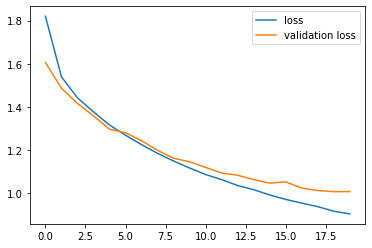

In [49]:
df_history[["loss", "validation loss"]].plot()

<AxesSubplot:>

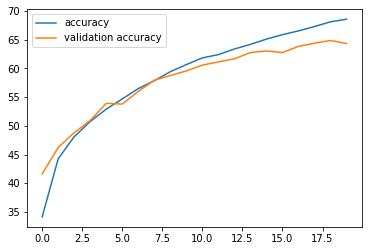

In [50]:
df_history[["accuracy", "validation accuracy"]].plot()

# Prediction

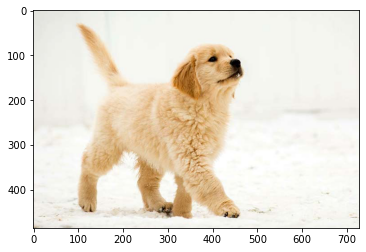

In [51]:
url = "https://www.akc.org/wp-content/uploads/2017/11/Golden-Retriever-Puppy.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

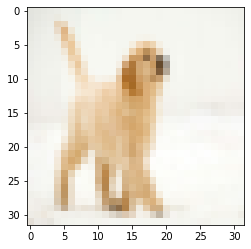

In [52]:
img_pred = transform(img)
plt.imshow(im_convert(img_pred))

In [53]:
img_input = img_pred.to(device).unsqueeze(0)
pred = model(img_input)
_, pred_label = torch.max(pred, 1)
class_cifar[pred_label.item()]

'bird'